# Prioritized Restreaming Algorithms for Balanced Graph Partitioning

#### Amel Awadelkarim

This notebook walks through the generation of all plots in the paper for a chosen test network after one trial of each method. Note that all results in the paper were averaged over 10 trials to account for random initializations and variability in tie-breaks.

## Importing modules

`Cython` is used to accelerate our implementation of reLDG. To build `Cython` code, uncomment the following lines:

In [14]:
!{sys.executable} -m pip install pip --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [20]:
# If reLDG cython module is not built, uncomment and execute the following:
!{sys.executable} -m pip install Cython
!python3 setup.py build_ext --inplace
!mv src/* .
!rm -rf src/

Defaulting to user installation because normal site-packages is not writeable
running build_ext
copying build/lib.linux-x86_64-cpython-310/src/alg.cpython-310-x86_64-linux-gnu.so -> src


We use `cvxpy` to run the linear program of BLP. If not installed, uncomment the following lines:

In [5]:
# If cvxpy is not installed, uncomment and execute the following:
!{sys.executable} -m pip install cvxpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 8.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 20.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 1.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 939.1 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.8 MB/s eta 0:00:00:00:01
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for 

In [21]:
%load_ext autoreload

# General modules
import os
import sys
import numpy as np
from scipy.stats import weightedtau

# Methods
import readdata
from blp import *
from shp import *
from reldg import *

# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Partitioning and Network Parameters

If not `web-NotreDame`, change the following cell:

In [22]:
network = 'web-NotreDame'
data_directory = '../data/'
num_shards = 16
num_iterations = 10
epsilon = 0.0

In [23]:
filename = data_directory + network + '.txt'
if not os.path.exists(filename):
    print("Network not in directory.")
    print("Please download the .txt file from SNAP repository (http://snap.stanford.edu/data/index.html) and place in " + data_directory + " directory.")

Edges are hardcoded, though can be changed if needed. If testing other than these example networks, ensure that `num_edges` holds the correct value.

In [24]:
edges_dict = {
    'soc-Pokec': 30622564,
    'com-LiveJournal': 68993773,
    'com-Orkut': 117185083, 
    'web-NotreDame': 1497134, 
    'web-Stanford': 2312497, 
    'web-Google': 5105039, 
    'web-BerkStan': 7600595
} # hardcoded for now
num_edges = edges_dict[network]

## Load network

In [13]:
print('Reading edge list in to memory...', end =" ")
neighbors_map, num_nodes, node_indices, edges = readdata.get_clean_data(data_directory, network, num_edges, shuffle=False)
print('Done.')

Reading edge list in to memory... Done.


In [14]:
if not os.path.exists(data_directory + network + '_edges.txt'):
    np.savetxt(data_directory + network + '_edges.txt', edges.astype(np.int32))
degrees = np.array([len(neighbor_list) for neighbor_list in neighbors_map])
if not os.path.exists(data_directory + network + '_degrees.txt'):
    np.savetxt(data_directory + network + '_degrees.txt', degrees.astype(np.int32))
print('Network: ', network)
print('Average degree: ', float(sum(degrees))/num_nodes)

Network:  web-NotreDame
Average degree:  6.777631098244246


In [15]:
initialization_file = data_directory + network + '_' + str(num_shards) + 'shards_init.txt'
if os.path.exists(initialization_file):
    initialization = np.loadtxt(initialization_file).astype(np.int32)
else:
    initialization = None

## Running methods

### Balanced Label Propagation

In [17]:
initialization, blpEdgeFracs, blpPeriodicity = blp(num_nodes, 
                                                   neighbors_map, 
                                                   num_shards, 
                                                   num_iterations, 
                                                   epsilon, 
                                                   return_periodicity = True,
                                                   initialization = initialization)

Loading or generating random initialization...
Initializing structures for collecting periodicity data...
Beginning BLP...
0: Internal edge fraction =  0.3097929899880915
1: Internal edge fraction =  0.42806695381694104
2: Internal edge fraction =  0.4826620452051053
3: Internal edge fraction =  0.5127471439358492
4: Internal edge fraction =  0.5353184419236381
5: Internal edge fraction =  0.5459876041312315
6: Internal edge fraction =  0.5563795511197094
7: Internal edge fraction =  0.5604354090804291
8: Internal edge fraction =  0.5690789071378842
9: Internal edge fraction =  0.5714696619197335


In [18]:
if not os.path.exists(initialization_file):
    np.savetxt(initialization_file, initialization)

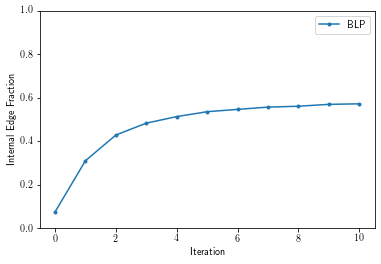

In [19]:
fig, ax = plt.subplots()
ax.plot(blpEdgeFracs, marker = '.', label = 'BLP')
ax.set_ylim((0.0,1.0))
ax.set_ylabel('Internal Edge Fraction')
ax.set_xlabel('Iteration')
ax.legend()

### Social Hash

In [20]:
shpIEdgeFracs, _ = shp(num_nodes, 
                       neighbors_map,
                       num_shards,
                       num_iterations,
                       initialization = np.loadtxt(initialization_file).astype(np.int32),
                       version = 'I')

Loading or generating random initialization...
Beginning SHP, version I...
0: Internal edge fraction =  0.29196696428045665
1: Internal edge fraction =  0.4696818502394605
2: Internal edge fraction =  0.5578236068689583
3: Internal edge fraction =  0.6266391142520783
4: Internal edge fraction =  0.6699408562235949
5: Internal edge fraction =  0.7046833518218973
6: Internal edge fraction =  0.729042959752608
7: Internal edge fraction =  0.7561167402208028
8: Internal edge fraction =  0.7743341285907185
9: Internal edge fraction =  0.7884413030745976


In [21]:
shpIIEdgeFracs, _ = shp(num_nodes, 
                        neighbors_map,
                        num_shards,
                        num_iterations,
                        initialization = np.loadtxt(initialization_file).astype(np.int32),
                        version = 'II')

Loading or generating random initialization...
Beginning SHP, version II...
0: Internal edge fraction =  0.2974859025642861
1: Internal edge fraction =  0.4574073763708451
2: Internal edge fraction =  0.525624062643392
3: Internal edge fraction =  0.5611510954304333
4: Internal edge fraction =  0.5878769979766006
5: Internal edge fraction =  0.6009233259847142
6: Internal edge fraction =  0.6160324613585991
7: Internal edge fraction =  0.6258582007916941
8: Internal edge fraction =  0.6358642207104229
9: Internal edge fraction =  0.640777996359059


In [24]:
klshpEdgeFracs, klshpPeriodicity = shp(num_nodes, 
                                       neighbors_map,
                                       num_shards,
                                       num_iterations,
                                       return_periodicity = True,
                                       initialization = np.loadtxt(initialization_file).astype(np.int32),
                                       version = 'KL')

Loading or generating random initialization...
Initializing structures for collecting periodicity data...
Beginning SHP, version KL...
0: Internal edge fraction =  0.28757047585441853
1: Internal edge fraction =  0.4384108864047224
2: Internal edge fraction =  0.5008595030690715
3: Internal edge fraction =  0.5409723640886708
4: Internal edge fraction =  0.5636242900323463
5: Internal edge fraction =  0.57955057615016
6: Internal edge fraction =  0.5944522530757527
7: Internal edge fraction =  0.6042317899723283
8: Internal edge fraction =  0.609420063043814
9: Internal edge fraction =  0.6153068097556202


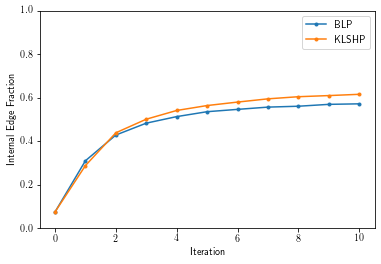

In [25]:
ax.plot(klshpEdgeFracs, marker = '.', label = 'KLSHP')
ax.legend()
fig

### Restreaming LDG

In [26]:
reldgEdgeFracs, _, reldgPeriodicity = reldg(num_nodes, 
                                            edges, 
                                            node_indices, 
                                            neighbors_map, 
                                            num_shards, 
                                            num_iterations, 
                                            epsilon, 
                                            return_periodicity=True,
                                            version = 'random')

Initializing structures for collecting periodicity data...
Stream order:  random
Computing static stream order, or first stream of dynamic order...
Beginning reLDG...
0: Internal edge fraction =  0.7142065099373955
1: Internal edge fraction =  0.8666594796054303
2: Internal edge fraction =  0.8843686400736341
3: Internal edge fraction =  0.8880947387540987
4: Internal edge fraction =  0.8897616537971464
5: Internal edge fraction =  0.8903785935494918
6: Internal edge fraction =  0.8910652900726603
7: Internal edge fraction =  0.8911912146329775
8: Internal edge fraction =  0.8914856425617766
9: Internal edge fraction =  0.8915762357706379


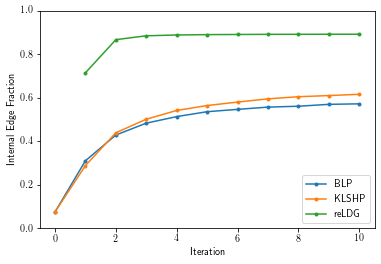

In [27]:
ax.plot(np.arange(1, num_iterations + 1), reldgEdgeFracs, marker = '.', label = 'reLDG')
ax.legend()
fig

#### Prioritized Restreaming

In [28]:
bfs_order, _ = bfs_disconnected(data_directory, network, num_nodes, neighbors_map, degrees)

In [29]:
reldgBFSEdgeFracs, _, _ = reldg(num_nodes, 
                                edges, 
                                node_indices, 
                                neighbors_map, 
                                num_shards, 
                                num_iterations, 
                                epsilon,
                                version = 'bfs',
                                bfs_order = bfs_order)

Stream order:  bfs
Computing static stream order, or first stream of dynamic order...
Beginning reLDG...
0: Internal edge fraction =  0.8058578474781795
1: Internal edge fraction =  0.8975417985741535
2: Internal edge fraction =  0.9116326662804376
3: Internal edge fraction =  0.9168290927407209
4: Internal edge fraction =  0.9201792296044111
5: Internal edge fraction =  0.9218651692213197
6: Internal edge fraction =  0.9233345910690497
7: Internal edge fraction =  0.9236299249299375
8: Internal edge fraction =  0.9239605901422812
9: Internal edge fraction =  0.924035782505636


In [31]:
ccs = compute_clustering_coefficients(data_directory, network, num_nodes, neighbors_map)

In [32]:
reldgCCEdgeFracs, _, _ = reldg(num_nodes, 
                               edges, 
                               node_indices, 
                               neighbors_map, 
                               num_shards, 
                               num_iterations, 
                               epsilon,
                               version = 'cc',
                               ccs = ccs)

Stream order:  cc
Computing static stream order, or first stream of dynamic order...
Beginning reLDG...
0: Internal edge fraction =  0.7230266647521302
1: Internal edge fraction =  0.8638538079269964
2: Internal edge fraction =  0.8805591956410171
3: Internal edge fraction =  0.8851495535340185
4: Internal edge fraction =  0.8861116534121253
5: Internal edge fraction =  0.8866062923325079
6: Internal edge fraction =  0.8871081787095993
7: Internal edge fraction =  0.8877205888015016
8: Internal edge fraction =  0.8878211472633377
9: Internal edge fraction =  0.8878664438677684


In [33]:
reldgDegEdgeFracs, _, _ = reldg(num_nodes, 
                                edges, 
                                node_indices, 
                                neighbors_map, 
                                num_shards, 
                                num_iterations, 
                                epsilon,
                                version = 'degree')

Stream order:  degree
Computing static stream order, or first stream of dynamic order...
Beginning reLDG...
0: Internal edge fraction =  0.7710401595165222
1: Internal edge fraction =  0.8808971083100697
2: Internal edge fraction =  0.8945395396324906
3: Internal edge fraction =  0.897730232448585
4: Internal edge fraction =  0.8985682196305519
5: Internal edge fraction =  0.8989804187308706
6: Internal edge fraction =  0.8991380509142893
7: Internal edge fraction =  0.899388994102835
8: Internal edge fraction =  0.8997232830435332
9: Internal edge fraction =  0.8997731093084069


In [34]:
reldgAEdgeFracs, reldgAOrders, _ = reldg(num_nodes, 
                                         edges, 
                                         node_indices, 
                                         neighbors_map, 
                                         num_shards, 
                                         num_iterations, 
                                         epsilon,
                                         return_orders = True,
                                         version = 'ambivalence')

Stream order:  ambivalence
Computing static stream order, or first stream of dynamic order...
Beginning reLDG...
0: Internal edge fraction =  0.7758298224690182
1: Internal edge fraction =  0.870895618051784
2: Internal edge fraction =  0.9005522109046139
3: Internal edge fraction =  0.9107276401239134
4: Internal edge fraction =  0.9138531058296276
5: Internal edge fraction =  0.9166107631073652
6: Internal edge fraction =  0.9174587155423068
7: Internal edge fraction =  0.918796777237188
8: Internal edge fraction =  0.9188302967244666
9: Internal edge fraction =  0.9195505127349138


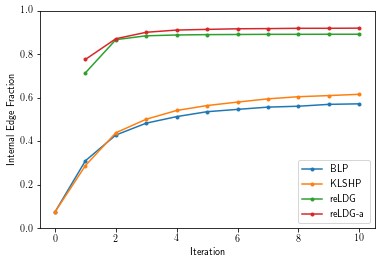

In [35]:
ax.plot(np.arange(1, num_iterations + 1), reldgAEdgeFracs, marker = '.', label = 'reLDG-a')
ax.legend()
fig

In [36]:
reldgGainEdgeFracs, reldgGainOrders, _ = reldg(num_nodes, 
                                               edges, 
                                               node_indices, 
                                               neighbors_map, 
                                               num_shards, 
                                               num_iterations, 
                                               epsilon,
                                               return_orders = True,
                                               version = 'gain')

Stream order:  gain
Computing static stream order, or first stream of dynamic order...
Beginning reLDG...
0: Internal edge fraction =  0.773062199938306
1: Internal edge fraction =  0.8149579353082955
2: Internal edge fraction =  0.8255645882017746
3: Internal edge fraction =  0.8383028992997598
4: Internal edge fraction =  0.8502340249067909
5: Internal edge fraction =  0.8535560778757342
6: Internal edge fraction =  0.8582768899894957
7: Internal edge fraction =  0.8614938548361599
8: Internal edge fraction =  0.8635014003445259
9: Internal edge fraction =  0.8637342248912995


## Partition Quality

Generates one row of Table 2 in the paper: final internal edge fraction after 10 iterations of synchronous algorithms (SHP-I/II/KL and BLP), and streaming (reLDG with static and dynamic stream orders). Must have run all above methods to execute.

In [37]:
fracs = [shpIEdgeFracs[-1], shpIIEdgeFracs[-1], klshpEdgeFracs[-1], blpEdgeFracs[-1], reldgEdgeFracs[-1], reldgBFSEdgeFracs[-1], reldgCCEdgeFracs[-1], reldgDegEdgeFracs[-1], reldgGainEdgeFracs[-1], reldgAEdgeFracs[-1]]
print("{: <13} {: ^7} {: ^7} {: ^7} {: ^7} | {: ^8} {: ^10} {: ^9} {: ^10} | {: ^8} {: ^8}".format('', 'shp-I', 'shp-II', 'kl-shp', 'blp', 'reldg', 'reldg-bfs', 'reldg-cc', 'reldg-deg', 'reldg-g', 'reldg-a'))
print('{: <13} {: ^7.3f} {: ^7.3f} {: ^7.3f} {: ^7.3f} | {: ^8.3f} {: ^10.3f} {: ^9.3f} {: ^10.3f} | {: ^8.3f} {: ^8.3f}'.format(network, *fracs))

               shp-I  shp-II  kl-shp    blp   |  reldg   reldg-bfs  reldg-cc  reldg-deg  | reldg-g  reldg-a 
web-NotreDame  0.788   0.641   0.615   0.571  |  0.892     0.924      0.888     0.900    |  0.864    0.920  


## Plots

### Period plots

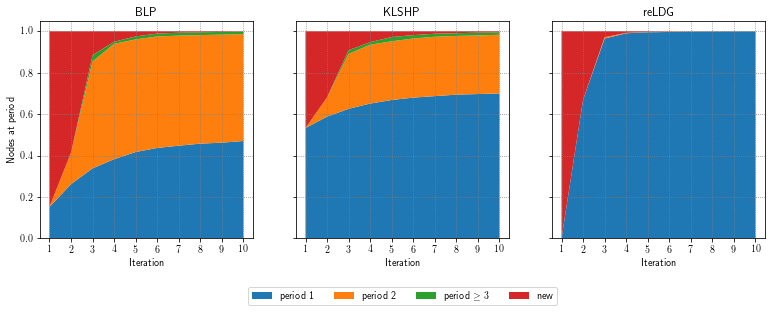

In [38]:
periodicities = [blpPeriodicity, klshpPeriodicity, reldgPeriodicity]
titles = ['BLP', 'KLSHP', 'reLDG']
period_data = []
for data in periodicities:
    new_row = np.sum(data[3:, :], axis=0) # sum periods >3
    data = np.concatenate((data[0:3,:], [new_row]), axis=0)
    data /= np.sum(data, axis=0)[None,:] # normalize
    y = data.tolist()
    y.append(y[0]) # put period 0 nodes at the end (for plot legend)
    period_data.append(y)

fig, ax = plt.subplots(1, 3, figsize = (13, 4), sharey=True)
x = range(1, num_iterations+1)
for i, title in enumerate(titles):
    ax[i].grid(linestyle=':', color='grey')
    ax[i].stackplot(x, period_data[i][1:], labels=['period 1', 'period 2', 'period $\geq 3$', 'new'])
    ax[i].set_title(title)
    ax[i].set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax[i].set_xlabel('Iteration')
    if i==0:
        ax[i].set_ylabel('Nodes at period')
    if i==1:
        # Put a legend below current axis
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

### Internal edge fraction vs incumbency parameter

Runs a bash script to automate and parallelize collection of partition qualities for `c=[-10,10]`. Can not proceed until script is finished!

In [45]:
# Shell script to run each method with c=[-10,10]
if not os.path.exists('../results/' + network + '_c_finalFrac.txt'):
    # replace web-NotreDame with your network, if different
    !bash incumbency.sh web-NotreDame
    # Must wait for the bash script to finish executing before continuing!

In [40]:
data = np.loadtxt('../results/' + network + '_c_finalFrac.txt')

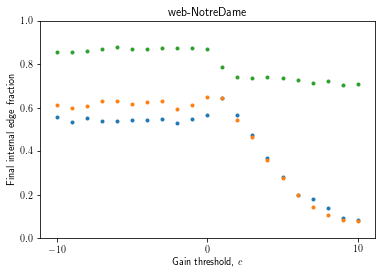

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(data)[:,0], np.array(data)[:,1], marker='.', label='BLP')
ax.scatter(np.array(data)[:,0], np.array(data)[:,2], marker='.', label='KL-SHP')
ax.scatter(np.array(data)[:,0], np.array(data)[:,3], marker='.', label='reLDG')
ax.set_title(network)
ax.set_xlabel(r'Gain threshold, $c$')
ax.set_ylabel('Final internal edge fraction')
ax.set_ylim((0.0,1.0))
ax.set_xticks([-10, 0, 10])

### Rank correlation matrix of stream orders

In [42]:
assert(len(reldgAOrders) == 2)
assert(len(reldgGainOrders) == 2)

orders = [ccs, -np.argsort(bfs_order), degrees, -reldgAOrders[0], -reldgAOrders[1]]
orders.extend(reldgGainOrders)
labels = ['CC', 'BFS', 'Deg', 'Amb-2', 'Amb-10', 'Gain-2', 'Gain-10']

In [43]:
# Computing kendall tau correlations
taus = np.zeros((len(orders), len(orders)))
for i in range(len(orders)):
    for j in range(i+1):
        tau = weightedtau(orders[i], orders[j])[0]
        taus[i,j] = tau
        if i != j:
            taus[j,i] = tau

Done.


Text(0.5, 1, 'web-NotreDame')

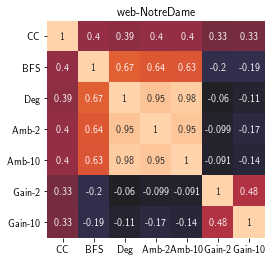

In [44]:
# Plotting kendall tau heat map
fig = plt.figure()
ax = sns.heatmap(taus, annot=True, square=True, xticklabels=labels, yticklabels=labels, cbar=False, center=0.0)
ax.tick_params(axis='both', which='major')
ax.set_xticks(np.arange(len(labels))+0.5)
ax.set_yticks(np.arange(len(labels))+0.5)
ax.set_title(network)